In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm

# 論文の数値シミュレーションで使われているパラメータ
_s = 100
_T = 1
_sigma = 2
_dt = 0.005
_q = 0
_gamma = 0.1
_k = 1.5
_A = 140

def prepare_dataframe(symmetric = False):
    df = pd.DataFrame()

    # ランダムな価格系列を論文の通りに生成する
    _rand = (2 * np.random.randint(0, 2, size = int(1.0 / 0.005) + 1) - 1) * _sigma
    df['price_change'] = _rand * np.sqrt(_dt)
    df['price_change'] = df['price_change'].shift(1).fillna(0)
    df['price_mid'] = _s + df['price_change'].cumsum()

    df['time'] = df.index * _dt # 時刻

    df['delta_ask_plus_delta_bid'] = _gamma * _sigma ** 2 * (_T - df['time']) + 2 / _gamma * np.log(1 + _gamma / _k)

    df['price_indifference'] = 0 # エージェントの在庫を考慮した無差別価格 (後のシミュレーションで埋める)
    df['inventory'] = 0 # エージェントの株在庫 (後のシミュレーションで埋める)
    df['delta_ask'] = 0 # price_midからの売り指値の幅 (後のシミュレーションで埋める)
    df['delta_bid'] = 0 # price_midからの買い指値の幅 (後のシミュレーションで埋める)
    df['cash'] = 0 # 現金保有額 (後のシミュレーションで埋める)

    # インデックスを時間に設定
    df = df.set_index('time', drop = True)
    df = df.drop('price_change', axis = 1)

    # 時刻0の初期条件を設定
    _price_mid = df.iloc[0, df.columns.get_loc('price_mid')]
    _inventory = df.iloc[0, df.columns.get_loc('inventory')]
    _price_indifference = _price_mid - _inventory * _gamma * _sigma ** 2 * (_T - df.index[0])
    _delta = df.iloc[0, df.columns.get_loc('delta_ask_plus_delta_bid')] / 2

    df.iloc[0, df.columns.get_loc('price_indifference')] = _price_indifference
    if symmetric == False:
        df.iloc[0, df.columns.get_loc('delta_ask')] = _price_indifference + _delta - _price_mid
        df.iloc[0, df.columns.get_loc('delta_bid')] = _price_indifference - _delta - _price_mid
    else:
        df.iloc[0, df.columns.get_loc('delta_ask')] = _delta
        df.iloc[0, df.columns.get_loc('delta_bid')] = -_delta
    df.iloc[0, df.columns.get_loc('cash')] = 0

    return df

def calc_lambda(delta):
    return _A * np.exp(-1 * _k * delta)

def run_simulation(df_target, symmetric = False):
    df = df_target.copy()
    for _i in range(1, len(df), 1):
        _prev_price_mid = df.iloc[_i - 1, df.columns.get_loc('price_mid')]
        _prev_delta_ask = df.iloc[_i - 1, df.columns.get_loc('delta_ask')]
        _prev_delta_bid = df.iloc[_i - 1, df.columns.get_loc('delta_bid')]
        _probability_ask =  calc_lambda(np.abs(_prev_delta_ask)) * _dt
        _probability_bid =  calc_lambda(np.abs(_prev_delta_bid)) * _dt
        _prev_inventory = df.iloc[_i - 1, df.columns.get_loc('inventory')]
        _prev_cash = df.iloc[_i - 1, df.columns.get_loc('cash')]

        # 論文の通り、確率に基づいて指値の成立を判定する
        _random_value = np.random.uniform()
        if _random_value <= _probability_bid:
            # 買い指値が成立
            df.iloc[_i, df.columns.get_loc('inventory')] = _prev_inventory + 1
            df.iloc[_i, df.columns.get_loc('cash')] = _prev_cash - (_prev_price_mid + _prev_delta_bid)
        elif _random_value < _probability_ask + _probability_bid:
            # 売り指値が成立
            df.iloc[_i, df.columns.get_loc('inventory')] = _prev_inventory - 1
            df.iloc[_i, df.columns.get_loc('cash')] = _prev_cash + (_prev_price_mid + _prev_delta_ask)
        else:
            # ポジションを維持
            df.iloc[_i, df.columns.get_loc('inventory')] = _prev_inventory
            df.iloc[_i, df.columns.get_loc('cash')] = _prev_cash
        
        # この時間の各種値を更新
        _price_mid = df.iloc[_i, df.columns.get_loc('price_mid')]
        _inventory = df.iloc[_i, df.columns.get_loc('inventory')]
        _price_indifference = _price_mid - _inventory * _gamma * _sigma ** 2 * (_T - df.index[_i])
        _delta = df.iloc[_i, df.columns.get_loc('delta_ask_plus_delta_bid')] / 2

        df.iloc[_i, df.columns.get_loc('price_indifference')] = _price_indifference
        if symmetric == False:
            df.iloc[_i, df.columns.get_loc('delta_ask')] = _price_indifference + _delta - _price_mid
            df.iloc[_i, df.columns.get_loc('delta_bid')] = _price_indifference - _delta - _price_mid
        else:
            df.iloc[_i, df.columns.get_loc('delta_ask')] = _delta
            df.iloc[_i, df.columns.get_loc('delta_bid')] = -_delta
    
    return df

def render_result(df):
    _fig, _axs = plt.subplots(3, sharex = True, figsize = (8, 6), gridspec_kw={'height_ratios': [1, 0.5, 0.5]})
    
    _axs[0].plot(df['price_mid'], label = '仲値', color = 'black')
    _axs[0].plot(df['price_indifference'], label = '無差別価格', color = 'lime')
    _axs[0].scatter(df.index, df['price_mid'] + df['delta_ask'], marker = '.', label = '売指値', color = 'red', s = 10)
    _axs[0].scatter(df.index, df['price_mid'] + df['delta_bid'], marker = 'o', label = '買指値', color = 'red', s = 10)
    _axs[0].grid()
    _axs[0].legend()

    _axs[1].plot(df['inventory'], label = '在庫', color = 'blue')
    _axs[1].grid()
    _axs[1].legend()

    _axs[2].plot(df['cash'] + df['inventory'] * df['price_mid'], label = '資産', color = 'blue')
    _axs[2].grid()
    _axs[2].legend()

    _fig.show()


100%|██████████| 1000/1000 [02:14<00:00,  7.41it/s]


count    1000.000000
mean       64.196688
std         5.658909
min        45.354892
25%        60.211394
50%        63.941811
75%        67.965680
max        84.352479
dtype: float64

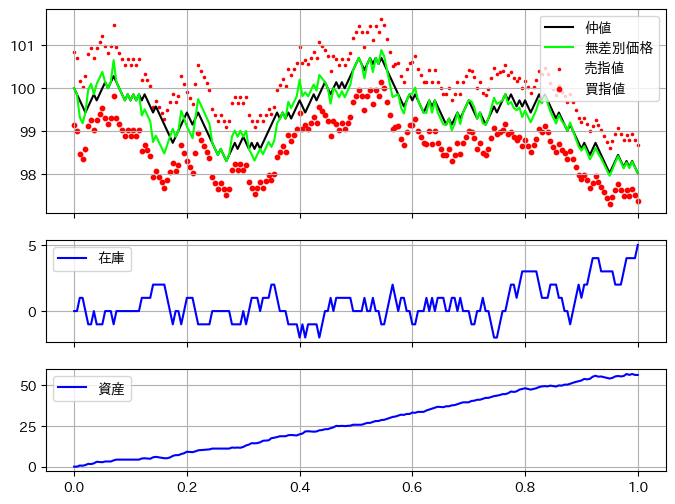

In [2]:
results = []

for _i in tqdm(range(1000)):
    df = prepare_dataframe()
    df = run_simulation(df)
    _final_wealth = df.iloc[-1, df.columns.get_loc('cash')] + df.iloc[-1, df.columns.get_loc('inventory')] * df.iloc[-1, df.columns.get_loc('price_mid')]
    results.append(_final_wealth)

render_result(df)
series_results = pd.Series(results)
series_results.describe()

100%|██████████| 1000/1000 [02:16<00:00,  7.30it/s]


count    1000.000000
mean       67.388864
std        13.770087
min         4.467965
25%        60.211779
50%        67.921807
75%        75.058784
max       114.347901
dtype: float64

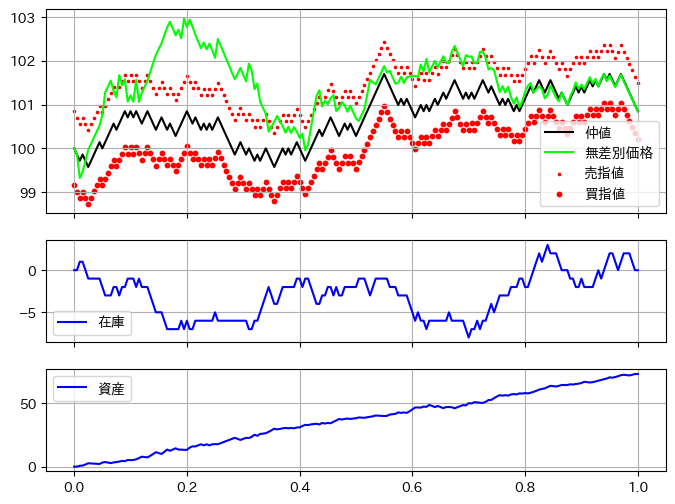

In [3]:
results = []

for _i in tqdm(range(1000)):
    df = prepare_dataframe(symmetric = True)
    df = run_simulation(df, symmetric = True)
    _final_wealth = df.iloc[-1, df.columns.get_loc('cash')] + df.iloc[-1, df.columns.get_loc('inventory')] * df.iloc[-1, df.columns.get_loc('price_mid')]
    results.append(_final_wealth)

render_result(df)
series_results = pd.Series(results)
series_results.describe()